<a href="https://colab.research.google.com/github/tom-schoener/ml-probability/blob/master/tfp-evaluation/notebooks/air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -qU tensorflow==2.0.0a0

from datetime import datetime, timedelta

import collections
from scipy.interpolate import interp1d
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

    100% |████████████████████████████████| 79.9MB 322kB/s 
    100% |████████████████████████████████| 61kB 20.1MB/s 
    100% |████████████████████████████████| 3.0MB 11.2MB/s 
    100% |████████████████████████████████| 419kB 20.2MB/s 


# Air Quality Test Data
Source: https://archive.ics.uci.edu/ml/datasets/Air+quality

hosted CSV: https://raw.githubusercontent.com/tom-schoener/ml-probability/master/data/air-quality/AirQualityUCI.csv

In [4]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/tom-schoener/ml-probability/master/data/air-quality/AirQualityUCI.csv", delimiter=";", decimal=",")
df_raw.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [5]:
# Cleanup
df = df_raw.copy()

# Remove empty rows and columns
# NMHC(GT) has < 20% values
df.dropna(thresh=2, inplace=True)
df.drop(df.columns[[4, 15, 16]], axis=1, inplace=True)

# -200 is missing data => NaN
df[df == -200] = np.nan

# Date and DateTime
date_time_col = pd.to_datetime(df['Date'] + " " + df['Time'], format="%d/%m/%Y %H.%M.%S")
df.insert(loc=0, column='Date_Time', value=date_time_col)
df.drop(["Date", "Time"], axis=1, inplace=True)

# Date index 
df.set_index(pd.DatetimeIndex(df['Date_Time']), inplace=True)

# Sanitized data frame
print("shape: " + str(df.shape))
df.head()

shape: (9357, 13)


,Date_Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


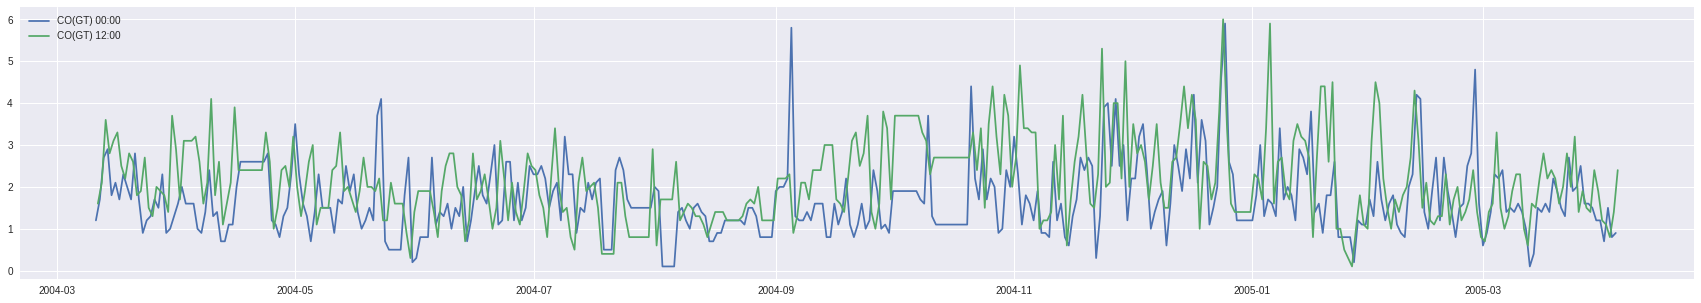

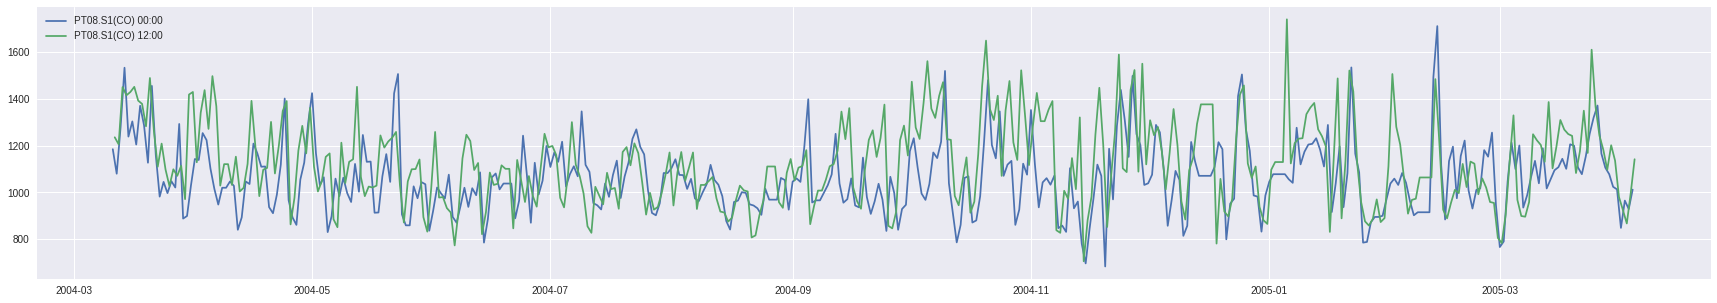

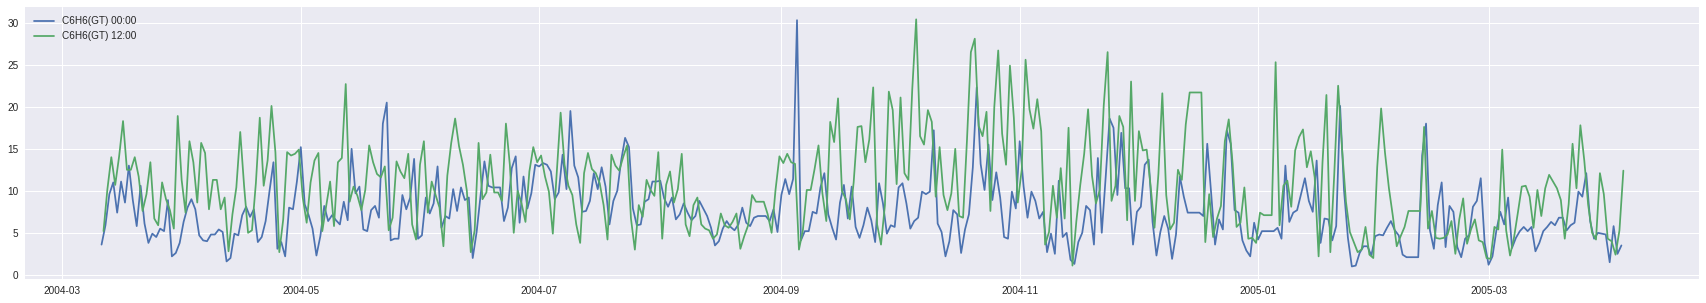

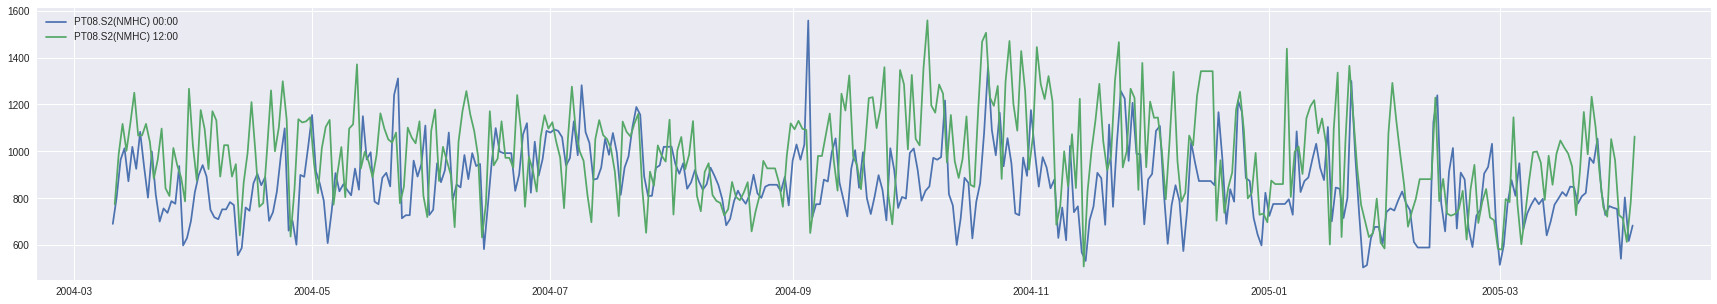

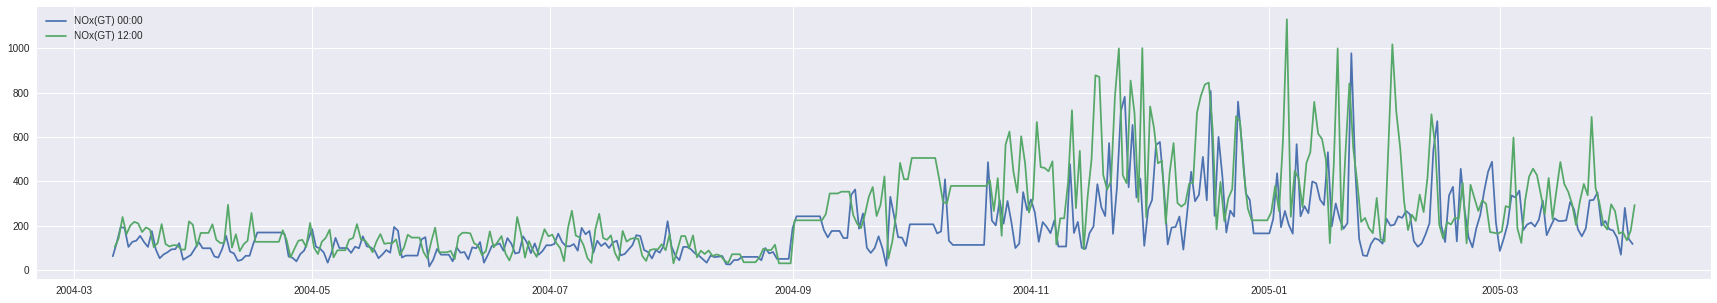

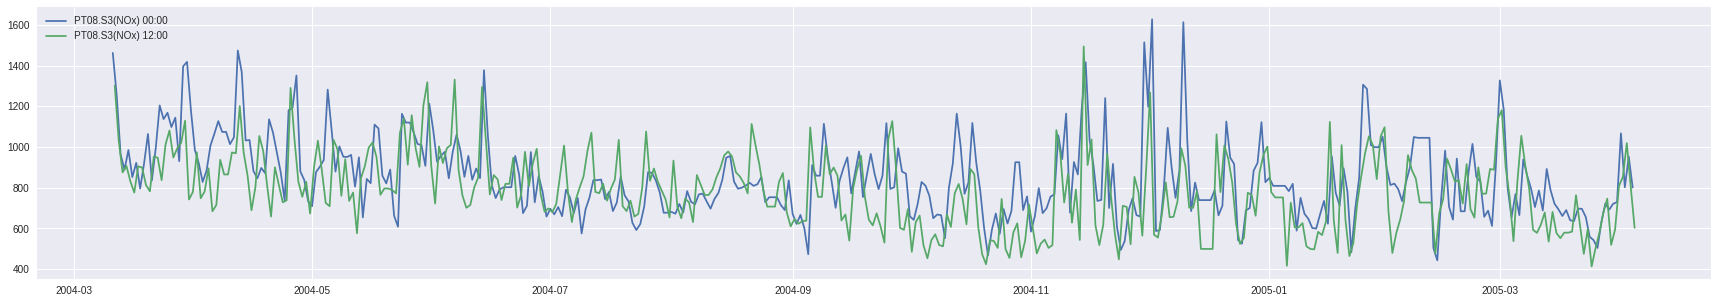

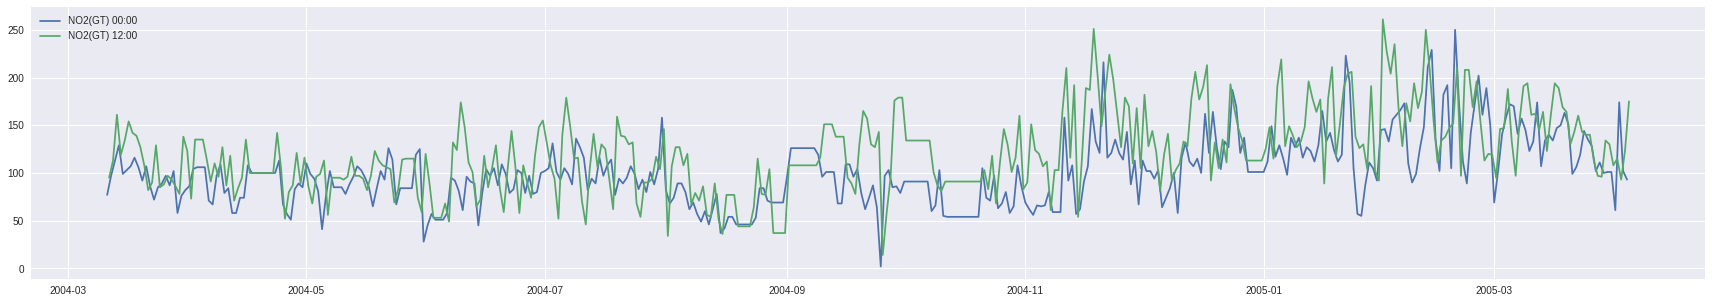

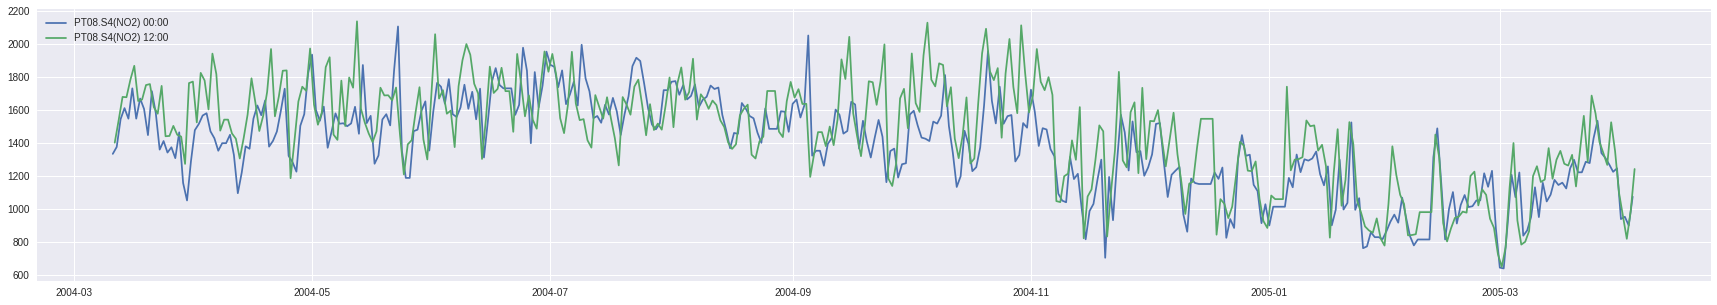

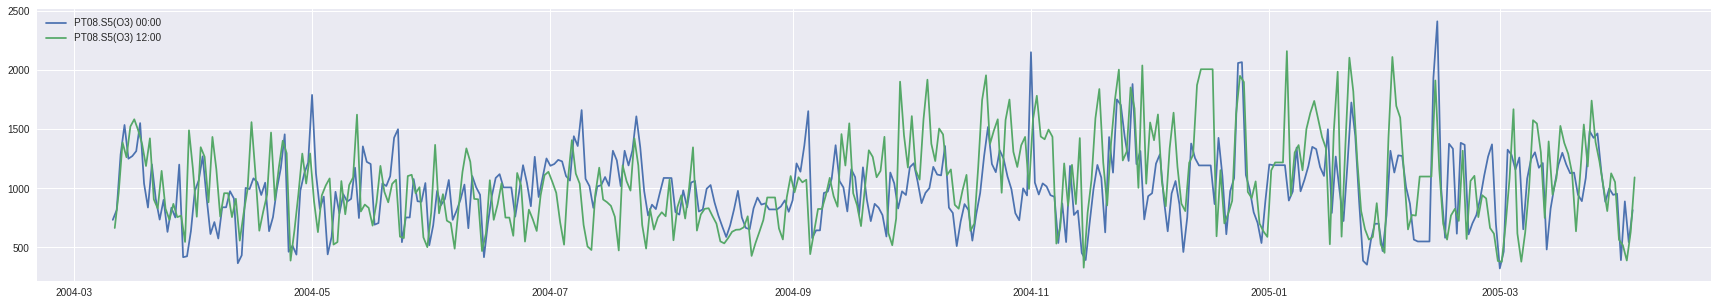

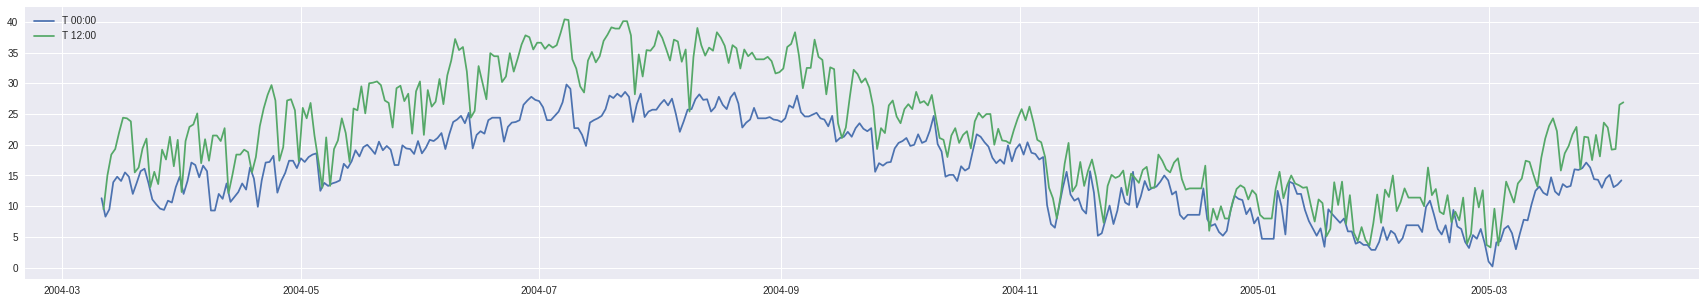

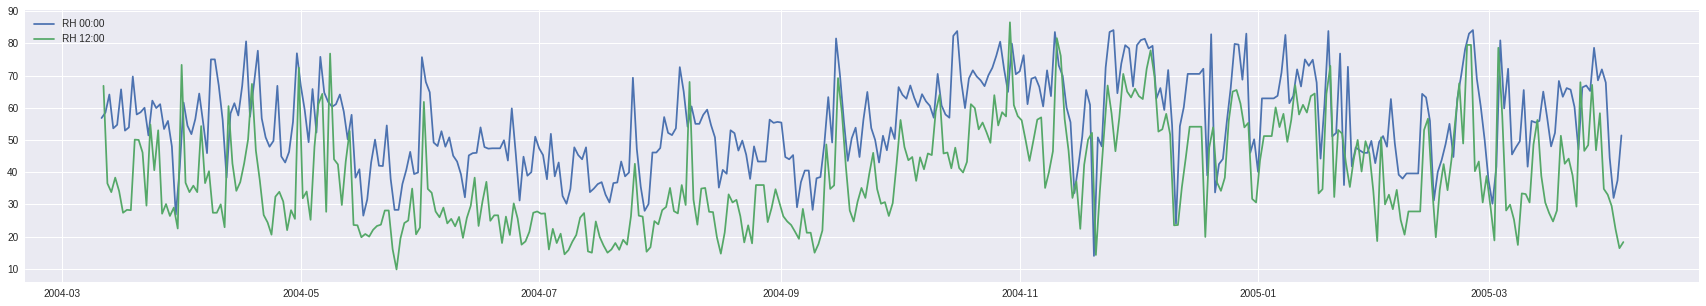

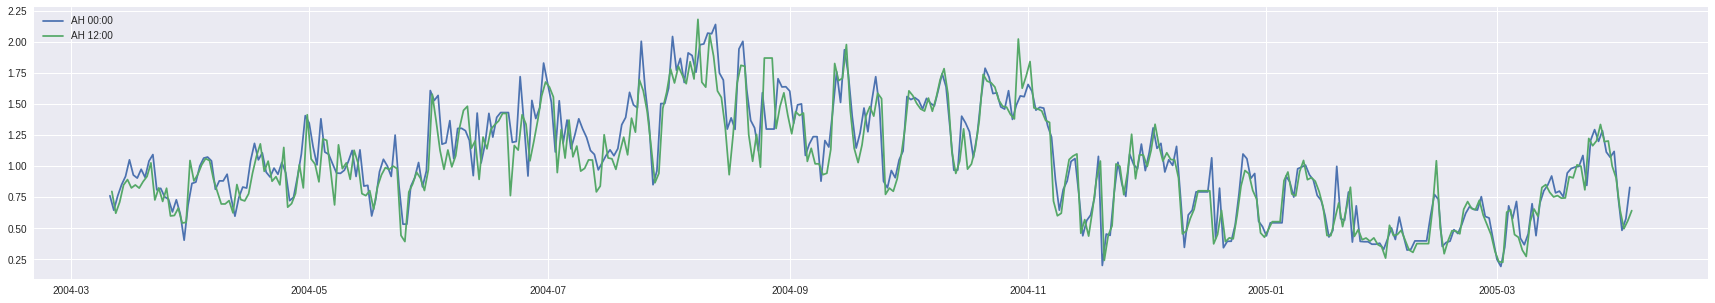

In [6]:
# Plots

def create_day_range(hour, freq='1D'):
  start = df['Date_Time'][0]
  end = df['Date_Time'][df.shape[0] - 1]
  
  start = start.replace(day=start.day + 1, hour=hour)
  unique_dates_col = pd.date_range(start=start, end=end, freq=freq)
  
  new_df = pd.DataFrame(df, index=unique_dates_col)
  new_df.fillna(inplace=True, method="pad")
  return new_df

def plot_at_hour(hour, column):
  hour_df = create_day_range(hour)
  hour_temp_col = hour_df[column]

  x = np.arange(hour_temp_col.shape[0])
  hour_temp_interp = interp1d(x=x , y=hour_temp_col, kind="cubic")
  plt.plot(hour_df['Date_Time'], hour_temp_interp(x), )


def plot_night_day(column):
  plt.figure(figsize=(30,5))
  plot_at_hour(0, column)
  plot_at_hour(12, column)
  plt.legend([column + ' 00:00', column + ' 12:00'], loc='upper left')
  plt.show()
  
for col in df.columns:
  if (col == "Date_Time"):
    continue
  plot_night_day(col)
